In [1]:
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
import operator
from typing import Annotated
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchRun

llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0) 

In [10]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [50]:
def search_tavily(state):

    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}

In [37]:
def search_wikipedia(state):
    search_docs = WikipediaLoader(query=state['question'], load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

In [51]:
def search_duck_duck_go(state):
    search = DuckDuckGoSearchRun()
    search_docs = search.invoke(state['question'])    
    return {"context": [search_docs]}

In [39]:
def generate_answer(state):
    context = state['context']
    question = state['question']
    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

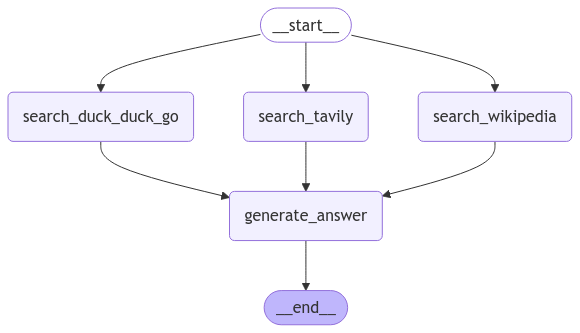

In [52]:
from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END

# Add nodes
builder = StateGraph(State)


# Initialize each node with node_secret 
builder.add_node("search_tavily",search_tavily)
builder.add_node("search_duck_duck_go",search_duck_duck_go)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_tavily")
builder.add_edge(START, "search_duck_duck_go")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_duck_duck_go", "generate_answer")
builder.add_edge("search_tavily", "generate_answer")

builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
graph.invoke({"question":"Explain me what's a linear regression and add the formula"})

/home/patrick/langgraph_study/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


{'question': "Explain me what's a linear regression and add the formula",
 'answer': AIMessage(content='Linear regression is a statistical method used in various machine learning models to predict the value of unknown data using related data values. It is used to study the relationship between a dependent variable and an independent variable. The linear regression formula is represented as y = mx + b, where y is the dependent variable, x is the independent variable, m is the slope of the regression line, and b is the y-intercept. This formula helps in understanding and predicting how one variable affects the other. Linear regression is a powerful statistical tool with advantages such as ease of use and applicability to various computational systems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 2702, 'total_tokens': 2822, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_to

In [57]:
graph.invoke({"question":"Explain me what's a linear regression and include the formula"})['answer'].content

/home/patrick/langgraph_study/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


'Linear regression is a statistical method used to determine the relationship between two variables: the dependent variable (y) and the independent variable (x). The formula for linear regression is y = mx + b, where y is the dependent variable, x is the independent variable, m is the slope of the regression line (or the regression coefficient), and b is the y-intercept. This equation allows you to predict the mean value of the dependent variable given the values of the independent variables that you specify. Linear regression finds the constant and coefficient values for the independent variables for a line that best fits your sample data. It simplifies understanding the relationship between variables by finding patterns in data, allowing predictions based on the influence of one variable on another. Linear regression is widely used in various industries such as medicine, sports, environmental science, and finance. It is a valuable statistical technique for professionals to make predi